In [9]:
# pip install matplotlib
# !pip install scikit-image

In [151]:
import numpy as np
import torch
import torchvision
# import cv2
import base64
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
import torch.nn as nn
import random
import matplotlib.image as mpimg
from skimage.transform import resize
from torchvision import transforms
from PIL import Image


In [152]:
# Set seeds for reproducibility
seed_value = 42

# Set PyTorch seed
torch.manual_seed(seed_value)

# Set NumPy seed
np.random.seed(seed_value)
random.seed(seed_value)

# If using CUDA (GPU), set the following flag
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable benchmark mode for deterministic results
torch.cuda.manual_seed_all(seed_value)

In [431]:

class mnist_dataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.image_size = 56
        self.grids_size = 28
        self.num_grid = int(2*self.image_size/self.grids_size)
        self.num_classes = 10
        self.labels_size = 15
        self.num_images = 0
        self.bw_threshold = 0.5
    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self,index):
        multiple_object_image = torch.zeros((self.image_size,self.image_size))
        image_labels = torch.zeros(int(self.num_grid*(self.labels_size)))
        class_rank_start = 5 #the first 5 are reserved for object_found_probability and bounding box coordinates
        num_images = random.choice([1,2,3,4])
        quadrants = random.sample([0,1,2,3], num_images)
        for i_image in range(num_images):
            grid_labels = torch.zeros((self.labels_size)) 
            self.num_images+=1
            i_quadrant =  random.sample(quadrants, 1)[0]
            quadrants.remove(i_quadrant)
            if i_image == 0:
                theera_or_mnist = random.choice([0,1])
                if theera_or_mnist == 0:
                    label = num_images = random.choice([0,1,2,3,4,5,6,7,8,9])
                    image_path = f'{label}.png'
                    image = mpimg.imread(image_path)
                    grid_labels[class_rank_start+label] = 1
                    image = resize(image,(28,28,1))
                    image = np.moveaxis(image, -1, 0)
                    image = torch.tensor(image)
                else:
                    image, label = self.original_dataset[index]
                image = (image >= self.bw_threshold)
                if num_images<3:
                    random_size = np.random.randint(14, 56)  # Random integer between 14 and 56
                    image = resize(image[0].numpy(), (random_size, random_size))
                    image = image[np.newaxis,:]
                    image = self.inject_matrix(-1,image)
                else:
                    image = self.inject_matrix(i_quadrant,image)
                grid_labels[class_rank_start+label] = 1
            if i_image ==1:
                label = num_images = random.choice([0,1,2,3,4,5,6,7,8,9])
                image_path = f'{label}.png'
                image = mpimg.imread(image_path)
                image = (image >= self.bw_threshold)
                grid_labels[class_rank_start+label] = 1
                image = resize(image,(28,28,1))
                image = np.moveaxis(image, -1, 0)
                image = self.inject_matrix(i_quadrant,image)
            if i_image >1:
                image, label = self.original_dataset[np.random.randint(256)]
                image = (image >= self.bw_threshold)
                grid_labels[class_rank_start+label] = 1
                image = self.inject_matrix(i_quadrant,image)
            box_center_h, box_center_w, box_h, box_w = self.coordinates_calculation_relative_2_image(image)
            grid_image, grid_labels = self.labels_per_grid(image,box_center_h, box_center_w, box_h, box_w, grid_labels)
            grid_image = grid_image[np.newaxis,:]
            quadrant_grid = self.object_quadrant_location(box_center_h, box_center_w)
            image_labels[quadrant_grid*grid_labels.size(0):(quadrant_grid+1)*grid_labels.size(0)] = grid_labels
            multiple_object_image += grid_image
        return multiple_object_image,image_labels

    def inject_matrix(self,i_quadrant,smaller_tensor):
        # Get the shape of the matrices
        # Create a larger tensor of size (200, 700) filled with zeros
        larger_tensor = np.zeros((56,56), dtype=np.float32)

        # target_size = (150, 150)
        # smaller_tensor = smaller_tensor.unsqueeze(0)
        smaller_tensor = smaller_tensor.squeeze()
        # Get the dimensions of the smaller tensor
        smaller_rows, smaller_cols = smaller_tensor.shape
        
        # Generate random starting coordinates within the valid range
        if i_quadrant == -1:
            row_start = np.random.randint(0, larger_tensor.shape[0] - smaller_rows + 1)
            col_start = np.random.randint(0, larger_tensor.shape[1] - smaller_cols + 1)
        if i_quadrant == 0:
            row_start = 0
            col_start = 0
        if i_quadrant == 1:
            row_start = 0
            col_start = 28
        if i_quadrant == 2:
            row_start = 28
            col_start = 0
        if i_quadrant == 3:
            row_start = 28
            col_start = 28        
        # Inject the smaller tensor into the larger tensor at the random location
        larger_tensor[row_start:row_start + smaller_rows, col_start:col_start + smaller_cols] = smaller_tensor
        return larger_tensor[np.newaxis,:]
    def coordinates_calculation_relative_2_image(self,image):
        non_zero_pixels = np.argwhere(image[0] != 0)
    
        if len(non_zero_pixels) == 0:
            # Handle the case where there are no non-zero pixels
            return 0, 0, 0, 0
        h_min, w_min = non_zero_pixels.min(axis=0)
        h_max, w_max = non_zero_pixels.max(axis=0)
    
        box_h = h_max - h_min
        box_w = w_max - w_min
        box_center_h = h_min + 0.5 * box_h
        box_center_w = w_min + 0.5 * box_w
    
        return box_center_h, box_center_w, box_h, box_w
    # def coordinates_calculation_relative_2_image(self,image):
    #     h_min = np.Inf
    #     h_max = -1
    #     w_min = np.Inf
    #     w_max = -1
    #     h_image = image.shape[1]
    #     w_image = image.shape[2]
    #     min_found = 0
    #     for i_h in range(h_image):
    #         for i_w in range(w_image):
    #             if image[:,i_h,i_w] != 0:
    #                 if h_min > i_h:
    #                     h_min = i_h
    #                 if w_min > i_w:
    #                     w_min = i_w
    #                 if h_min > -1 and i_h > h_max:
    #                     h_max = i_h
    #                 if w_min > -1 and i_w > w_max:
    #                     w_max = i_w
    #     box_h = h_max - h_min
    #     box_w = w_max - w_min
    #     box_center_h = h_min + 0.5*box_h
    #     box_center_w = w_min + 0.5*box_w
    #     return box_center_h, box_center_w, box_h, box_w

    
    def labels_per_grid(self,image,box_center_h, box_center_w, box_h, box_w, grid_labels):
        num_of_grids = image.shape[1]//self.image_size
        for i_grid in range(num_of_grids):
            grid_start = i_grid * self.image_size
            grid_end = (i_grid+1) * self.image_size
            grid_image = image[0,grid_start:grid_end,grid_start:grid_end]
            grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w = self.coordinates_calculation_relative_2_grid(grid_image,box_center_h, box_center_w, box_h, box_w)
            grid_labels[1:5] = torch.tensor([grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w]) 
        if box_center_h > grid_start and box_center_w > grid_start and box_center_h < grid_end and box_center_w < grid_end:
            grid_labels[0] = 1
        return grid_image, grid_labels #torch.tensor([grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w])
            
    
    def coordinates_calculation_relative_2_grid(self, grid_image,box_center_h, box_center_w, box_h, box_w):
        grid_box_center_h = box_center_h/self.image_size
        grid_box_center_w = box_center_w/self.image_size
        grid_box_h = box_h / self.image_size
        grid_box_w = box_w / self.image_size
        return grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w

    def object_quadrant_location(self,box_center_h, box_center_w):
        image_center = self.image_size/2 - 1 # '-1' because we start at 0 (0-55). use one varibale for center as we receive square images.
        quadrant_grid = np.Inf
        if box_center_h >= image_center: 
            if box_center_w >= image_center: 
                quadrant_grid = 3
            else: 
                quadrant_grid = 2
        if box_center_h < image_center:
            if box_center_w >=image_center:
                quadrant_grid = 1
            else:
                quadrant_grid = 0
        return quadrant_grid

In [432]:
train_ds = torchvision.datasets.MNIST(root="data", train=True,  download=True, transform=torchvision.transforms.ToTensor())
train_ds = mnist_dataset(train_ds)


In [433]:
class MyCnn(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Dropout2d(p=0.1)
    )
    self.conv2 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Dropout2d(p=0.1)
    )
    self.linear_relu_stack = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=147456, out_features=128),
      torch.nn.ReLU(),
      torch.nn.Dropout(p=0.1),
      torch.nn.Linear(in_features=128, out_features=60),
      torch.nn.ReLU()
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    logits = self.linear_relu_stack(x)
    return logits

In [434]:
def draw_box(image, label,ds):
    confidence_thresholds = 0.7
    i_quadrant = 0
    object_found = 0
    fig, ax = plt.subplots()
    while i_quadrant <=3 and object_found < ds.num_images:
        grid_labels = label[i_quadrant*ds.labels_size:(i_quadrant+1)*ds.labels_size][:5]
        if F.softmax(grid_labels[0],dim=0) >= confidence_thresholds:
            print(i_quadrant)
            object_found += 1
            print('object found') if object_found else print('object not found')
            box_center_h, box_center_w, box_height, box_width = grid_labels[1:]
            box_center_h =np.floor(box_center_h * train_ds.image_size)
            box_center_w =np.floor(box_center_w*train_ds.image_size)
            box_height =np.floor(box_height*train_ds.image_size)
            box_width =np.floor(box_width*train_ds.image_size)
            y_min = box_center_h - 0.5 * box_height
            x_min = box_center_w - 0.5 * box_width
            # Display the image
            ax.imshow(np.array(image[0,:,:]))
            rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        i_quadrant += 1
    return ax

tensor([[1.0000, 0.2411, 0.2054, 0.3393, 0.1964, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.2411, 0.7500, 0.3393, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.7411, 0.2411, 0.3036, 0.3393, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.7589, 0.7500, 0.3393, 0.0714, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
0
object found
1
object found
2
object found
3
object found


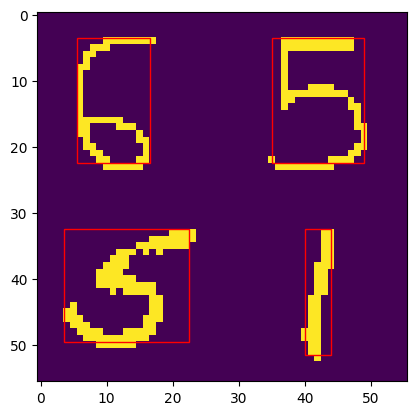

In [436]:
train_ds = torchvision.datasets.MNIST(root="data", train=True,  download=True, transform=torchvision.transforms.ToTensor())
train_ds = mnist_dataset(train_ds)
# test_ds = torchvision.datasets.MNIST(root="data", train=False,  download=True, transform=torchvision.transforms.ToTensor())
# test_ds = mnist_dataset(test_ds)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=256)
# test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10)
i_batch = 5
for batch in train_dl:
    # print(batch[0].squeeze().size())
    # mnist_image = batch[0].squeeze()
    a,b = batch
    print(b[i_batch].view(4,15))
    draw_box(a[i_batch], b[i_batch],train_ds)
    # a = a.unsqueeze(0)
    # a = F.interpolate(a, size=(28,28), mode='bilinear', align_corners=False)
    # plt.figure()
    # plt.imshow(a.squeeze().squeeze())
    break

In [437]:
def boxes_intersection(box_pred, box_gt):
    x1, y1, h1, w1 = box_pred[:,[0,4,8,12]],box_pred[:,[1,5,9,13]],box_pred[:,[2,6,10,14]],box_pred[:,[3,7,11,15]]
    x2, y2, h2, w2 = box_gt[:,[0,4,8,12]],box_gt[:,[1,5,9,13]],box_gt[:,[2,6,10,14]],box_gt[:,[3,7,11,15]]
    # Calculate half-width and half-height for each rectangle
    half_width1, half_height1 = w1 / 2, h1 / 2
    half_width2, half_height2 = w2 / 2, h2 / 2

    # Calculate the coordinates of the top-left and bottom-right corners for each rectangle
    top_left1 = (x1 - half_width1, y1 - half_height1)
    bottom_right1 = (x1 + half_width1, y1 + half_height1)

    top_left2 = (x2 - half_width2, y2 - half_height2)
    bottom_right2 = (x2 + half_width2, y2 + half_height2)

    # Calculate the intersection area
    x_overlap = torch.max(torch.tensor(0), torch.min(bottom_right1[0], bottom_right2[0]) - torch.max(top_left1[0], top_left2[0]))
    y_overlap = torch.max(torch.tensor(0), torch.min(bottom_right1[1], bottom_right2[1]) - torch.max(top_left1[1], top_left2[1]))

    intersection_area = x_overlap * y_overlap

    return intersection_area

def calculate_iou(boxes_pred, boxes_gt):
    box_pred_h, box_pred_w = boxes_pred[:,[2,6,10,14]],boxes_pred[:,[3,7,11,15]]
    box_gt_h, box_gt_w = boxes_gt[:,[2,6,10,14]],boxes_gt[:,[3,7,11,15]]
    intersection_area = boxes_intersection(boxes_pred, boxes_gt)
    box_pred_area = box_pred_h * box_pred_w
    box_gt_area = box_gt_h * box_gt_w
    union_area = box_pred_area + box_gt_area - intersection_area
    box_exist_mask = box_gt_area>0
    iou = intersection_area[box_exist_mask] / union_area[box_exist_mask]
    

    return iou.mean()

In [438]:
# box_1 = torch.tensor([0.75,0.75,0.5,0.5,0.75,0.75,0.5,0.5,0.25,0.25,0.5,0.5,0.25,0.25,0.5,0.5]).view(1,-1)
# box_2 = torch.tensor([0.75,0.75,0.5,0.5,0.75,0.75,0.5,0.5,0.75,0.75,0.5,0.5,0.75,0.75,0.5,0.5]).view(1,-1)
# calculate_iou(box_1, box_2)

In [439]:

class YOLOLoss(nn.Module):
    def __init__(self, num_classes=10, lambda_coord=5.0, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj


    def extracting_predictions(self):
        obj_indexes = torch.tensor([0,15,30,45])
        coords_indexes = torch.tensor([1,2,3,4,16,17,18,19,31,32,33,34,46,47,48,49])
        classes_grid_1 = torch.arange(5,15)
        classes_grid_2 = torch.arange(20,30)
        classes_grid_3 = torch.arange(35,45)
        classes_grid_4 = torch.arange(50,60)
        class_indexes = torch.cat([classes_grid_1,classes_grid_2,classes_grid_3,classes_grid_4])
        return obj_indexes, coords_indexes, class_indexes
    
    def forward(self, predictions, targets):
        """
        Calculate YOLO loss.

        Args:
        - predictions: Tensor of shape (batch_size, 15, S, S)
        - targets: Tensor of shape (batch_size, 15, S, S)

        Returns:
        - loss: Scalar tensor representing the total YOLO loss.
        """
        obj_indexes, coords_index, class_indexes = self.extracting_predictions()
        # Extract predicted and target values
        pred_coords = predictions[:, coords_index]
        pred_obj_prob = predictions[:,obj_indexes]
        pred_class_probs = predictions[:,class_indexes]
        # pred_class_probs = nn.functional.softmax(predictions[:, 5:], dim = 1)
        # pred_class_probs = torch.argmax(pred_class_probs, dim = 1)
        
        
        target_coords = targets[:, coords_index]
        target_obj_prob = targets[:,obj_indexes]
        target_class_probs = targets[:,class_indexes]
        # target_class_probs = torch.argmax(target_class_probs, dim = 1)
        
        # Calculate localization loss
        
        loc_loss = torch.sum((pred_coords[:2] - target_coords[:2])**2)
        loc_loss += torch.sum((torch.sqrt(pred_coords[2:]) - torch.sqrt(target_coords[2:]))**2)

        
        # Calculate confidence loss (object present)
        obj_mask = target_obj_prob > 0
        conf_loss_obj = torch.sum((pred_obj_prob[obj_mask] - target_obj_prob[obj_mask])**2)
        
        # Calculate confidence loss (object not present)
        noobj_mask = target_obj_prob == 0
        conf_loss_noobj = torch.sum((pred_obj_prob[noobj_mask])**2)
        
        # Calculate class prediction loss
        class_loss = torch.sum((pred_class_probs - target_class_probs)**2)
        # Combine the individual loss terms
        loss = (
            self.lambda_coord * loc_loss +
            conf_loss_obj +
            self.lambda_noobj * conf_loss_noobj +
            class_loss
        )
        return loss



In [440]:
device = "cuda" if torch.cuda.is_available() else "cpu"

myCnn = MyCnn().to(device)
loss = YOLOLoss()
opt = torch.torch.optim.Adam(myCnn.parameters(), lr=1e-3)
model_path = 'mult_obj_multi_cell_mnist_bw-13.pt'#'mult_obj_mnist-39.pt'
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # Use 'cuda' if you saved the model on GPU

# Step 3: Load the state dictionary into your model
myCnn.load_state_dict(checkpoint)

<All keys matched successfully>

In [441]:
batch_size = 256
train_ds = torchvision.datasets.MNIST(root="data", train=True,  download=True, transform=torchvision.transforms.ToTensor())
train_ds = mnist_dataset(train_ds)


# subset_indices = list(range(1))
# train_ds = Subset(train_ds,subset_indices)


test_ds = torchvision.datasets.MNIST(root="data", train=False,  download=True, transform=torchvision.transforms.ToTensor())
test_ds = mnist_dataset(test_ds)

val_test_size = len(test_ds)
val_size = int(0.8*val_test_size)
val_subset_indices = list(range(val_size))
test_subset_indices = list(range(val_size,val_test_size))
val_ds = Subset(test_ds,val_subset_indices)
test_ds = Subset(test_ds,test_subset_indices)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(seed_value))
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)



for t in range(20):
    for idx, (x, y) in enumerate(train_dl):
      myCnn.train()
      x, y = x.to(device), y.to(device)
      # plt.imshow(x[0,0,:,:].cpu())
      logits = myCnn(x)
      l = loss(logits, y)
      opt.zero_grad()
      l.backward()
      opt.step()
      if idx % 50 == 0: print(f"Epoch: {t}, Loss: {l.item()}")
    myCnn.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      iou = 0
      for x, y in val_dl:
        validation_batch_size = y.size(0)
        x, y = x.to(device), y.to(device)
        logits = myCnn(x)
        
        _,coords_indexes, class_indexes = loss.extracting_predictions()
        iou += calculate_iou(logits[:,coords_indexes], y[:,coords_indexes])
        class_probabilities = nn.functional.softmax(logits[:,class_indexes], dim=1)
        class_predictions = torch.argmax(class_probabilities.view(validation_batch_size,train_ds.num_grid,train_ds.num_classes),dim =2)
        class_gt = torch.argmax(y[:,class_indexes].view(validation_batch_size,train_ds.num_grid,train_ds.num_classes),dim =2)
        total += y.size(0)*train_ds.num_grid
        correct += (class_predictions == class_gt).sum().item()
    iou_mean = iou/total
    print(f"Epoch: {t}, Val_class_accuracy: {correct/total}; box_coordinates_accuracy: {iou_mean.item()}")
    torch.save(myCnn.state_dict(), f"./mult_obj_multi_cell_mnist_bw-{t}.pt")


Epoch: 0, Loss: 310.67913818359375
Epoch: 0, Loss: 276.53564453125
Epoch: 0, Loss: 273.07220458984375
Epoch: 0, Loss: 255.79425048828125
Epoch: 0, Loss: 243.55523681640625
Epoch: 0, Val_class_accuracy: 0.89646875; box_coordinates_accuracy: 0.0006232758751139045
Epoch: 1, Loss: 239.40335083007812


KeyboardInterrupt: 

In [308]:
model_path = 'mult_obj_multi_cell_mnist_bw-9.pt'
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # Use 'cuda' if you saved the model on GPU

# Step 3: Load the state dictionary into your model
myCnn.load_state_dict(checkpoint)

<All keys matched successfully>

In [442]:
with torch.no_grad():
  correct = 0
  total = 0
  for x, y in test_dl:
    x, y = x.to(device), y.to(device)
    validation_batch_size = y.size(0)
    logits = myCnn(x)
    _,_, class_indexes = loss.extracting_predictions()  
    class_probabilities = nn.functional.softmax(logits[:,class_indexes], dim=1)
    class_predictions = torch.argmax(class_probabilities.view(validation_batch_size,train_ds.num_grid,train_ds.num_classes),dim =2)
    class_gt = torch.argmax(y[:,class_indexes].view(validation_batch_size,train_ds.num_grid,train_ds.num_classes),dim =2)
    break

gt class class: tensor([5, 0, 4, 3], device='cuda:0')
predicted class: tensor([5, 0, 4, 0], device='cuda:0')
0
object found
1
object found
2
object found
3
object found
0
object found
1
object found
2
object found
3
object found


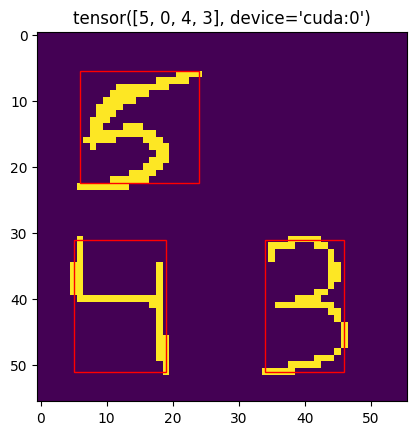

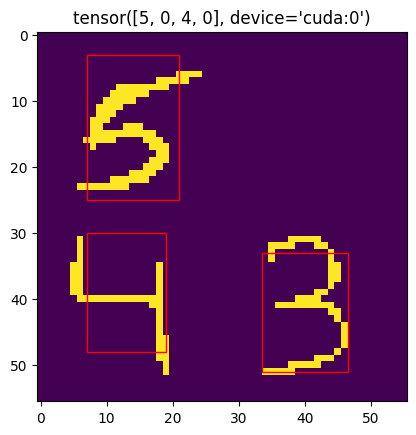

In [443]:
i_batch = 2
print(f'gt class class: {class_gt[i_batch]}')
print(f'predicted class: {class_predictions[i_batch]}')
b = logits
b.cpu()
images = x
images.cpu()

draw_box(images[i_batch].cpu(), y[i_batch].cpu(),train_ds)
plt.title(f'{class_gt[i_batch]}')
draw_box(images[i_batch].cpu(), b[i_batch].cpu(),train_ds)
plt.title(f'{class_predictions[i_batch]}')
plt.show()

In [397]:
# i_batch = 9
# print(f'gt class class: {torch.argmax(y[:,5:],dim=1)[i_batch]}')
# print(f'predicted class: {torch.argmax(class_prediction,dim=1)[i_batch]}')
# ax1 = draw_box(x[i_batch].cpu(), y[i_batch,1].item(),y[i_batch,2].item(),y[i_batch,3].item(),y[i_batch,4].item())
# b = logits
# b.cpu()
# images = x
# images.cpu()

# ax2 = draw_box(images[i_batch].cpu(), b[i_batch,1].item(),b[i_batch,2].item(),b[i_batch,3].item(),b[i_batch,4].item())
# plt.show()

In [398]:
# def calculate_accuracy(predictions, ground_truths, iou_threshold=0.5, confidence_threshold=0.5):
#     total_predictions = len(predictions)
#     correct_count = count_correct_predictions(predictions, ground_truths, iou_threshold, confidence_threshold)
#     accuracy = correct_count / total_predictions if total_predictions > 0 else 0
#     return accuracy


# def count_correct_predictions(predictions, ground_truths, iou_threshold=0.5, confidence_threshold=0.5):
#     correct_count = 0

#     for pred in predictions:
#         # Apply confidence threshold
#         if pred[0] < confidence_threshold:
#             continue

#         # Find the ground truth with the highest IoU
#         max_iou = max([calculate_iou(pred[1:5], gt[1:5]) for gt in ground_truths], default=0)

#         # Check if the prediction is correct
#         if max_iou >= iou_threshold:
#             correct_count += 1

#     return correct_count



<class 'numpy.ndarray'>
(1, 56, 56)
torch.Size([1, 1, 56, 56])
tensor([[4, 0, 0, 8]], device='cuda:0')
0
object found
1
object found
2
object found
3
object found


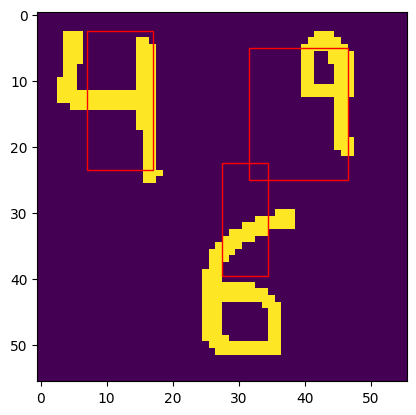

In [457]:
image_path = "4_9_6.png"
image = mpimg.imread(image_path)
image = resize(image,(56,56,1))
image = (image >= train_ds.bw_threshold).astype(np.uint8)
print(type(image))
image = np.moveaxis(image, -1, 0)
print(image.shape)
# Step 3: Plot the image using plt.imshow
# plt.imshow(image[0])
# plt.axis("off")  # Optionally turn off axis labels
# plt.show()
image = torch.tensor(image).unsqueeze(0)
image = image.to(device)
image = image.to(torch.float32)
print(image.size())
with torch.no_grad():
    logits = myCnn(image)
    _,_, class_indexes = loss.extracting_predictions()  
    class_probabilities = nn.functional.softmax(logits[:,class_indexes], dim=1)
    class_predictions = torch.argmax(class_probabilities.view(1,train_ds.num_grid,train_ds.num_classes),dim =2)
    print(class_predictions)
    # _,coords_indexes, class_indexes = loss.extracting_predictions()
    # iou += calculate_iou(logits[:,coords_indexes], y[:,coords_indexes])
    # class_probabilities = nn.functional.softmax(logits[:,class_indexes], dim=1)
    # class_predictions = torch.argmax(class_probabilities.view(validation_batch_size,train_ds.num_grid,train_ds.num_classes),dim =2)
    # class_gt = torch.argmax(y[:,class_indexes].view(validation_batch_size,train_ds.num_grid,train_ds.num_classes),dim =2)
    # total += y.size(0)*train_ds.num_grid
    # correct += (class_predictions == class_gt).sum().item()
    draw_box(image[0].cpu(), logits[0].cpu(),train_ds)

In [342]:
image

tensor([[[[0.1655, 0.1655, 0.1655,  ..., 0.1655, 0.1655, 0.1655],
          [0.1655, 0.1655, 0.1655,  ..., 0.1655, 0.1655, 0.1655],
          [0.1655, 0.1655, 0.1655,  ..., 0.1655, 0.1655, 0.1655],
          ...,
          [0.1655, 0.1655, 0.1655,  ..., 0.1655, 0.1655, 0.1655],
          [0.1655, 0.1655, 0.1655,  ..., 0.1655, 0.1655, 0.1655],
          [0.1655, 0.1655, 0.1655,  ..., 0.1655, 0.1655, 0.1655]]]],
       device='cuda:0')

In [337]:
logits[0][45]

tensor(0.9955, device='cuda:0')

In [338]:
F.softmax(logits[0][45],dim=0)

tensor(1., device='cuda:0')

In [323]:
class_probabilities.view(1,4,10)

tensor([[[0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202,
          0.0212, 0.0202],
         [0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202,
          0.0605, 0.0202],
         [0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202,
          0.1725, 0.0202],
         [0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202, 0.0202,
          0.0202, 0.0202]]], device='cuda:0')

[[[0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  ...
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]]

 [[0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  ...
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]]

 [[0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  ...
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]]

 ...

 [[0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341166 0.23897658 0.26101348 0.27659827]
  [0.22341

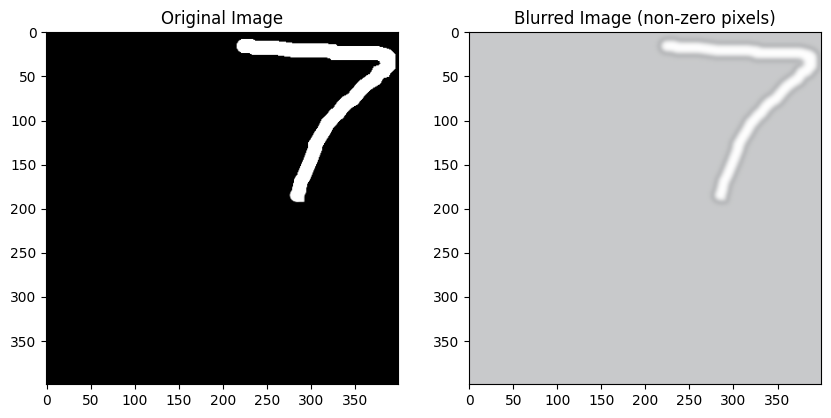

In [163]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

image_path = "theera_7_second_quadrant.png"
image_np = mpimg.imread(image_path)

# Blur only non-zero pixels
non_zero_pixels = image_np != 0
image_np_non_zero = np.where(non_zero_pixels, image_np, 1e-10)  # Replace zero values with a small number
blurred_image = gaussian_filter(image_np_non_zero, sigma=3)

# Display original and blurred images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image_np, cmap='gray')
ax1.set_title("Original Image")

ax2.imshow(blurred_image, cmap='gray')
ax2.set_title("Blurred Image (non-zero pixels)")
print(blurred_image)
plt.show()

plt.show()


In [402]:
logits.view(1,4,15)

tensor([[[0.3777, 0.1044, 0.0390, 0.0977, 0.1036, 0.0109, 0.0000, 0.0000,
          0.0000, 0.0089, 0.0000, 0.0000, 0.0000, 0.0483, 0.0000],
         [0.3580, 0.1367, 0.1683, 0.1157, 0.1627, 0.0590, 0.0000, 0.1352,
          0.0000, 0.0363, 0.0749, 0.1252, 0.0000, 0.0122, 0.0000],
         [0.2839, 0.1380, 0.1043, 0.1120, 0.1108, 0.0000, 0.0000, 0.4780,
          0.0312, 0.0000, 0.0000, 0.1030, 0.0000, 0.0000, 0.0000],
         [0.1734, 0.0000, 0.1071, 0.0000, 0.1653, 0.1326, 0.0000, 0.1099,
          0.0000, 0.0000, 0.0715, 0.0952, 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')

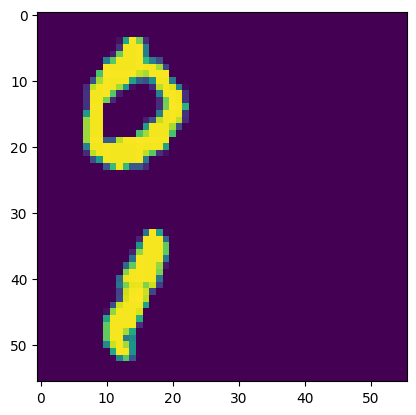

In [140]:
image_0 = x[3][0].cpu()
plt.imshow(image_0)

In [443]:
image_7 = x[0][0].cpu()

In [444]:
image_7_mask = image_7>0
image_7_mask = image_7_mask.cpu()

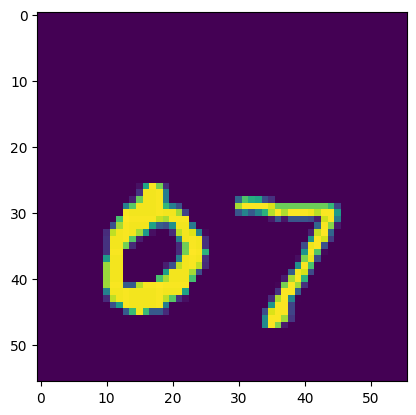

In [445]:
image_0[image_7_mask] = image_7[image_7_mask]
plt.imshow(image_0.cpu())

torch.Size([1, 1, 56, 56])
object not found


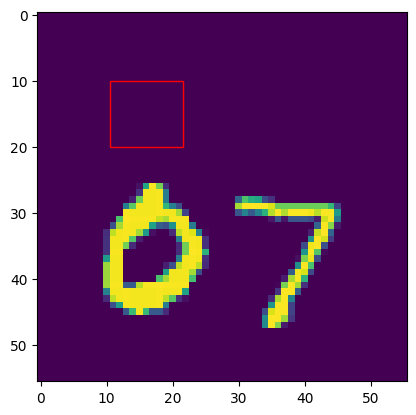

In [446]:
image_0 = image_0.unsqueeze(0).unsqueeze(0)
print(image_0.shape)
image_0 = image_0.to(device)
with torch.no_grad():
    logits = myCnn(image_0)
    # _,coords_indexes, class_indexes = loss.extracting_predictions()
    # iou += calculate_iou(logits[:,coords_indexes], y[:,coords_indexes])
    # class_probabilities = nn.functional.softmax(logits[:,class_indexes], dim=1)
    # class_predictions = torch.argmax(class_probabilities.view(validation_batch_size,train_ds.num_grid,train_ds.num_classes),dim =2)
    # class_gt = torch.argmax(y[:,class_indexes].view(validation_batch_size,train_ds.num_grid,train_ds.num_classes),dim =2)
    # total += y.size(0)*train_ds.num_grid
    # correct += (class_predictions == class_gt).sum().item()
    draw_box(image_0[0].cpu(), logits[0].cpu(),train_ds)

In [453]:
logits.view(1,4,15)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1795, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4797, 0.2926, 0.1979, 0.1637, 0.1827, 0.0415, 0.0000, 0.3950,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1043],
         [0.7011, 0.2847, 0.2905, 0.1797, 0.2111, 0.0000, 0.0000, 0.2074,
          0.0186, 0.0000, 0.0000, 0.0000, 0.1473, 0.0256, 0.0000]]],
       device='cuda:0')

object found


<Axes: >

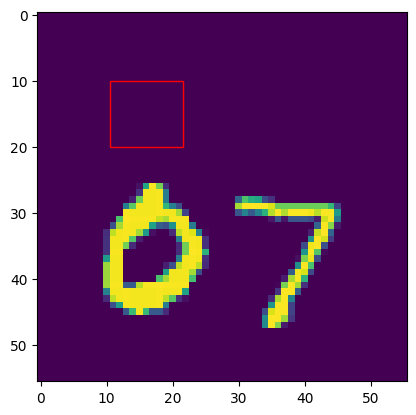

In [454]:
draw_box(image_0[0].cpu(), logits[0].cpu(),train_ds)